# Load segmentation, localise and save as h5

Segment a stack of images and then manually label a couple, then check how well the model segmented them.

In [1]:
import napari
from cellpose import models
from octopuslite import utils, tile
import numpy as np

import sys
sys.path.append('macrohet/')
from notify import send_sms

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = '5'
column = '4'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             #set_channel=1, 
                             set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)

# This is where the segmentation will go

In [6]:
model = models.Cellpose(
                        #gpu=True, 
                        model_type='cyto', 
                        net_avg=True, 
                        device=torch.device('cuda')
                        )

In [7]:
images

dask.array<sum-aggregate, shape=(75, 2, 6048, 6048), dtype=uint64, chunksize=(1, 2, 2016, 2016), chunktype=numpy.ndarray>

In [8]:
input_images = images[:,0,...]#.compute().compute().astype(np.uint16)
input_images

dask.array<getitem, shape=(75, 6048, 6048), dtype=uint64, chunksize=(1, 2016, 2016), chunktype=numpy.ndarray>

In [13]:
masks_stack = list()
for n, frame in tqdm(enumerate(input_images), total = len(input_images)):

    frame = frame.compute().compute().astype(np.uint16)
    masks, flows, styles, diams = model.eval(frame, 
                                             batch_size = 32, 
                                             channels = [0,0], 
                                             diameter = 325, 
                                             min_size = 2500, 
                                             progress = True)
    masks_stack.append(masks)
masks_stack = da.stack(masks_stack, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
view()

In [16]:
masks = masks_stack

### Lazy save out

In [23]:
np.save('/mnt/DATA/macrohet/segmentation/[5,4]_masks.npy', masks)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


# Check masks 

and perform a quick post-segmentation cleaning on them

In [24]:
masks

dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>

In [21]:
images

dask.array<sum-aggregate, shape=(75, 2, 6048, 6048), dtype=uint64, chunksize=(1, 2, 2016, 2016), chunktype=numpy.ndarray>

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 502, in mousePressEvent
    self._vispy_mouse_press(
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/base.py", line 184, in _vispy_mouse_press
    ev = self._vispy_canvas.events.mouse_press(**kwargs)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1067, in on_mouse_press
    self._process_mouse_event(mouse_press_callbacks, even

In [20]:
images.shape, masks.shape

((75, 2, 6048, 6048), (75, 6048, 6048))

In [19]:
v = napari.Viewer()
v.add_image(images, 
            channel_axis = 1, 
            colormap=['green', 'magenta'], 
            contrast_limits=[[100,6000],[0,3000]])
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(masks, name = 'masks')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f410bfff460>

## Post-segmentation editing

In [24]:
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion, square

In [108]:
###Q: do i need to remove small objects? don't think so
###Q: do i need to erode? no as am not binarising...
cleaned_masks = list()
for i, mask in tqdm(enumerate(masks), total = len(masks)):
    mask = binary_erosion(mask, square(5))
    mask = remove_small_holes(mask, area_threshold=50)
    cleaned_masks.append(mask)
cleaned_masks = np.stack(cleaned_masks, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [113]:
view(masks[37])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f09b5f966a0>

#### Reorder the channel axis for localisation

In [28]:
gfp = images[:,0,...]
rfp = images[:,1,...]
images = da.stack([gfp,rfp], axis = -1)
images

dask.array<stack, shape=(75, 6048, 6048, 2), dtype=uint64, chunksize=(1, 2016, 2016, 1), chunktype=numpy.ndarray>

In [ ]:
### convert to dask array so that it is compatible with images for localisation
masks = da.from_array(masks)

In [29]:
masks

dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>

In [30]:
images

dask.array<stack, shape=(75, 6048, 6048, 2), dtype=uint64, chunksize=(1, 2016, 2016, 1), chunktype=numpy.ndarray>

# Localise raw masks

Include size filter and measurements of fluorescence

In [25]:
feat = [
      "area",
      "major_axis_length",
      "minor_axis_length",
      "orientation",
      "mean_intensity",
        ]

In [31]:
objects = btrack.utils.segmentation_to_objects(
    masks, 
    images,
    properties = tuple(feat),
    use_weighted_centroid = False, 
)

[INFO][2023/01/24 01:57:55 pm] Localizing objects from segmentation...
24-Jan-23 13:57:55 - btrack._localization - INFO     - Localizing objects from segmentation...
[INFO][2023/01/24 01:57:55 pm] Found intensity_image data
24-Jan-23 13:57:55 - btrack._localization - INFO     - Found intensity_image data
[INFO][2023/01/24 02:13:51 pm] Objects are of type: <class 'dict'>
24-Jan-23 14:13:51 - btrack.dataio - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/01/24 02:13:51 pm] ...Found 31871 objects in 75 frames.
24-Jan-23 14:13:51 - btrack._localization - INFO     - ...Found 31871 objects in 75 frames.


In [36]:
objects = [o for o in objects if o.properties['area'] > 2500]

#### Find the efd?

In [ ]:
### finding the EFD
for obj in tqdm(objects):
    ### extract the intensity image (1ch only)
    glimpse = obj.properties['intensity_image'][...,0]
    ### pad the glimpse to ensure only one object is identifiable
    glimpse = np.pad(glimpse, pad_width = 1)
    ### find the contours (zero because only one object)
    contours = skimage.measure.find_contours(glimpse, fully_connected='high', level = 0.5)[0]
    ### get the efd
    efd = elliptic_fourier_descriptors(contours, order=100, normalize=True)
#     obj.properties = {'efd': efd}
    flatten_efd = efd.flatten()
    obj.properties = {'efd flat': flatten_efd}

In [37]:
with btrack.dataio.HDF5FileHandler(
     f'/mnt/DATA/macrohet/segmentation/({row},{column})_objects_d325.h5',
    'w', 
    obj_type='obj_type_1',
) as hdf:
    hdf.write_segmentation(masks)
    hdf.write_objects(objects)

[INFO][2023/01/24 02:42:15 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_d325.h5...
24-Jan-23 14:42:15 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_d325.h5...
[INFO][2023/01/24 02:42:59 pm] Writing objects/obj_type_1
24-Jan-23 14:42:59 - btrack.dataio - INFO     - Writing objects/obj_type_1
[INFO][2023/01/24 02:42:59 pm] Writing labels/obj_type_1
24-Jan-23 14:42:59 - btrack.dataio - INFO     - Writing labels/obj_type_1
[INFO][2023/01/24 02:42:59 pm] Loading objects/obj_type_1 (27397, 5) (27397 filtered: None)
24-Jan-23 14:42:59 - btrack.dataio - INFO     - Loading objects/obj_type_1 (27397, 5) (27397 filtered: None)
[INFO][2023/01/24 02:43:00 pm] Writing properties/obj_type_1/area (27397,)
24-Jan-23 14:43:00 - btrack.dataio - INFO     - Writing properties/obj_type_1/area (27397,)
[INFO][2023/01/24 02:43:00 pm] Writing properties/obj_type_1/major_axis_length (27397,)
24-Jan-23 14:43:00 - btrack.dataio - INFO     - Wri

In [29]:
objects[0]

{'ID': 0, 'x': 257.8385644029397, 'y': 104.5392053931591, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 36194, 'major_axis_length': 244.63142988672934, 'minor_axis_length': 204.21778412309249, 'orientation': -0.6250412899536294, 'mean_intensity-0': 1751.473890700116, 'mean_intensity-1': 343.58830192849643}

In [10]:
config = '/home/dayn/analysis/BayesianTracker/models/particle_config.json'

In [11]:
features = list(objects[0].properties.keys())

In [47]:
images

dask.array<stack, shape=(75, 6048, 6048, 2), dtype=uint64, chunksize=(1, 2016, 2016, 1), chunktype=numpy.ndarray>

In [48]:
%%time 
images = images.compute().compute()

CPU times: user 3h 43min 30s, sys: 8min 19s, total: 3h 51min 50s
Wall time: 8min 26s


In [52]:
type(images)

numpy.ndarray

In [ ]:
%%time 
masks = masks.compute()

In [53]:
masks.shape

(75, 6048, 6048)

In [8]:
with btrack.dataio.HDF5FileHandler(
     f'/mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5',
    'r', 
    obj_type='obj_type_1',
) as hdf:
#     hdf.write_segmentation(masks)
    objects = hdf.objects

[INFO][2023/01/25 01:41:40 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
[INFO][2023/01/25 01:41:40 PM] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/25 01:41:40 PM] Closing HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5


In [14]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(config)
    tracker.max_search_radius = 50
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = features

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
#     tracker.volume=((0, masks.shape[-2]), (0, masks.shape[-1]))
    tracker.volume=((0, 1200), (0, 1200))

    # track them (in interactive mode)
    tracker.track(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
    tracker.export(f"/mnt/DATA/macrohet/segmentation/[{int(row), int(column)}]_tracks.h5", obj_type="obj_type_1")
    

[INFO][2023/01/25 01:43:11 PM] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2023/01/25 01:43:11 PM] btrack (v0.5.0) library imported
[INFO][2023/01/25 01:43:11 PM] Starting BayesianTracker session
[INFO][2023/01/25 01:43:11 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2023/01/25 01:43:11 PM] Objects are of type: <class 'list'>
[INFO][2023/01/25 01:43:12 PM] Starting tracking... 
[INFO][2023/01/25 01:43:12 PM] Update using: ['MOTION', 'VISUAL']
[INFO][2023/01/25 01:43:12 PM] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2023/01/25 01:43:17 PM]  - Timing (Bayesian updates: 46.94ms, Linking: 3.31ms)
[INFO][2023/01/25 01:43:17 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2023/01/25 01:43:17 PM]  - Stats (Active: 658, Lost: 2923, Conflicts resolved: 4010)
[INFO][2023/01/25 01:43:17 PM] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2023/01/25 01:43:20 PM]  - Timing (B

GLPK Integer Optimizer 5.0
11100 rows, 9579 columns, 13608 non-zeros
9579 integer variables, all of which are binary
Preprocessing...
5550 rows, 9579 columns, 13608 non-zeros
9579 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5550
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
5550 rows, 9579 columns, 13608 non-zeros
*     0: obj =   2.916873288e+04 inf =   0.000e+00 (2142)
Perturbing LP to avoid stalling [1074]...
Removing LP perturbation [2150]...
*  2150: obj =   1.583120353e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2150: mip =     not found yet >=              -inf        (1; 0)
+  2150: >>>>>   1.583120353e+04 >=   1.583120353e+04   0.0% (1; 0)
+  2150: mip =   1.583120353e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOL

[INFO][2023/01/25 01:43:23 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5...
[INFO][2023/01/25 01:43:24 PM] Writing objects/obj_type_1
[INFO][2023/01/25 01:43:24 PM] Writing labels/obj_type_1
[INFO][2023/01/25 01:43:24 PM] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/25 01:43:24 PM] Writing properties/obj_type_1/area (26073,)
[INFO][2023/01/25 01:43:24 PM] Writing properties/obj_type_1/major_axis_length (26073,)
[INFO][2023/01/25 01:43:24 PM] Writing properties/obj_type_1/mean_intensity-0 (26073,)
[INFO][2023/01/25 01:43:24 PM] Writing properties/obj_type_1/mean_intensity-1 (26073,)
[INFO][2023/01/25 01:43:24 PM] Writing properties/obj_type_1/minor_axis_length (26073,)
[INFO][2023/01/25 01:43:24 PM] Writing properties/obj_type_1/orientation (26073,)
[INFO][2023/01/25 01:43:24 PM] Writing tracks/obj_type_1
[INFO][2023/01/25 01:43:24 PM] Writing dummies/obj_type_1
[INFO][2023/01/25 01:43:24 PM] Writing LBEP/obj_type_1
[INFO][2023/0

In [57]:
v = napari.Viewer()
v.add_image(images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
            contrast_limits=[[100,6000],[0,3000]])
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(
    masks, 
    name = 'masks', 
#     color = {1:'yellow'}, 
    opacity = 0.2
)
v.add_tracks(
                    data, 
                    properties=properties, 
                    graph=graph, 
                    name="Tracks 5,4", 
                    blending="translucent",
                    visible=False,
                )


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'Tracks 5,4' at 0x7f41173612b0>

# What if I downscale the images to be approx 1200x1600

In [58]:
masks.shape

(75, 6048, 6048)

In [60]:
from skimage.transform import rescale, resize, downscale_local_mean

In [62]:
6048/1200

5.04

In [104]:
masks_resized = list()
for t in tqdm(range(len(masks))):
    mask_resized = rescale(masks[t], 1200/6048, anti_aliasing=False)
    mask_resized *= 255/mask_resized.max()    # Uses 1 division and image.size multiplications
    masks_resized.append(mask_resized.astype(np.uint8))
masks_resized = np.stack(masks_resized, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [68]:
gfp.shape

(75, 6048, 6048)

In [70]:
gfp_images_resized = list()
for t in tqdm(range(len(gfp))):
    gfp_image_resized = rescale(gfp[t], 1200/6048, anti_aliasing=False)
    gfp_images_resized.append(gfp_image_resized)
gfp_images_resized = np.stack(gfp_images_resized, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [72]:
rfp_images_resized = list()
for t in tqdm(range(len(rfp))):
    rfp_image_resized = rescale(rfp[t], 1200/6048, anti_aliasing=False)
    rfp_images_resized.append(rfp_image_resized)
rfp_images_resized = np.stack(rfp_images_resized, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [74]:
resized_images = np.stack([gfp_images_resized,rfp_images_resized], axis = -1)

In [100]:
masks_resized.shape

(75, 1200, 1200)

In [76]:
resized_images.shape

(75, 1200, 1200, 2)

In [108]:
v = napari.Viewer()
v.add_image(resized_images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
        #/contrast_limits=[[100,6000],[0,3000]]
           )
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(
    masks_resized, 
    name = 'masks', 
#     color = {1:'yellow'}, 
    opacity = 0.2
)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f41716e55b0>

In [109]:
objects = btrack.utils.segmentation_to_objects(
    masks_resized, 
    resized_images,
    properties = tuple(feat),
    use_weighted_centroid = False, 
)

[INFO][2023/01/24 05:59:55 pm] Localizing objects from segmentation...
24-Jan-23 17:59:55 - btrack._localization - INFO     - Localizing objects from segmentation...
[INFO][2023/01/24 05:59:55 pm] Found intensity_image data
24-Jan-23 17:59:55 - btrack._localization - INFO     - Found intensity_image data
[INFO][2023/01/24 06:03:21 pm] Objects are of type: <class 'dict'>
24-Jan-23 18:03:21 - btrack.dataio - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/01/24 06:03:30 pm] ...Found 977134 objects in 75 frames.
24-Jan-23 18:03:30 - btrack._localization - INFO     - ...Found 977134 objects in 75 frames.


In [111]:
objects = [o for o in objects if o.properties['area'] > 500]

In [116]:
with btrack.dataio.HDF5FileHandler(
     f'/mnt/DATA/macrohet/segmentation/({row},{column})_objects_rescaled.h5',#
    'w', 
    obj_type='obj_type_1',
) as hdf:
    hdf.write_segmentation(masks_resized)
    hdf.write_objects(objects)

[INFO][2023/01/24 06:04:55 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
24-Jan-23 18:04:55 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
[INFO][2023/01/24 06:04:59 pm] Writing objects/obj_type_1
24-Jan-23 18:04:59 - btrack.dataio - INFO     - Writing objects/obj_type_1
[INFO][2023/01/24 06:04:59 pm] Writing labels/obj_type_1
24-Jan-23 18:04:59 - btrack.dataio - INFO     - Writing labels/obj_type_1
[INFO][2023/01/24 06:04:59 pm] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
24-Jan-23 18:04:59 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/24 06:05:00 pm] Writing properties/obj_type_1/area (26073,)
24-Jan-23 18:05:00 - btrack.dataio - INFO     - Writing properties/obj_type_1/area (26073,)
[INFO][2023/01/24 06:05:00 pm] Writing properties/obj_type_1/major_axis_length (26073,)
24-Jan-23 18:05:00 - btrack.dataio - INFO  

In [113]:
config = '/home/dayn/analysis/BayesianTracker/models/cell_config.json'

In [114]:
features = list(objects[0].properties.keys())

In [117]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(config)
    tracker.max_search_radius = 20
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = features

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, masks_resized.shape[-2]), (0, masks_resized.shape[-1]))

    # track them (in interactive mode)
    tracker.track(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
    tracker.export("/mnt/DATA/macrohet/segmentation/rescaled_[6,9]_tracks.h5", obj_type="obj_type_1")
    

[INFO][2023/01/24 06:05:57 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
24-Jan-23 18:05:57 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2023/01/24 06:05:57 pm] btrack (v0.5.0) library imported
24-Jan-23 18:05:57 - btrack.core - INFO     - btrack (v0.5.0) library imported
[INFO][2023/01/24 06:05:57 pm] Starting BayesianTracker session
24-Jan-23 18:05:57 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/01/24 06:05:57 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
24-Jan-23 18:05:57 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2023/01/24 06:05:57 pm] Objects are of type: <class 'list'>
24-Jan-23 18:05:57 - btrack.dataio - INFO     - Objects are of type: <class 'list'>
[INFO][2023/01/24 06:05:57 pm] Starting tracking... 
24-Jan-23 18:05:57

GLPK Integer Optimizer 5.0
12504 rows, 10966 columns, 15838 non-zeros
10966 integer variables, all of which are binary
Preprocessing...
6252 rows, 10966 columns, 15838 non-zeros
10966 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6252
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6252 rows, 10966 columns, 15838 non-zeros
*     0: obj =   3.430066727e+04 inf =   0.000e+00 (3183)
Perturbing LP to avoid stalling [1400]...
Removing LP perturbation [3114]...
*  3114: obj =   1.552941569e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3114: mip =     not found yet >=              -inf        (1; 0)
+  3115: >>>>>   1.553032011e+04 >=   1.553032011e+04   0.0% (2; 0)
+  3115: mip =   1.553032011e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/01/24 06:06:10 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/rescaled_[6,9]_tracks.h5...
24-Jan-23 18:06:10 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/rescaled_[6,9]_tracks.h5...
[INFO][2023/01/24 06:06:10 pm] Writing tracks/obj_type_1
24-Jan-23 18:06:10 - btrack.dataio - INFO     - Writing tracks/obj_type_1
[WARNING][2023/01/24 06:06:10 pm] Removing tracks/obj_type_1.
24-Jan-23 18:06:10 - btrack.dataio - WARNING  - Removing tracks/obj_type_1.
[INFO][2023/01/24 06:06:10 pm] Writing dummies/obj_type_1
24-Jan-23 18:06:10 - btrack.dataio - INFO     - Writing dummies/obj_type_1
[INFO][2023/01/24 06:06:10 pm] Writing LBEP/obj_type_1
24-Jan-23 18:06:10 - btrack.dataio - INFO     - Writing LBEP/obj_type_1
[INFO][2023/01/24 06:06:10 pm] Writing fates/obj_type_1
24-Jan-23 18:06:10 - btrack.dataio - INFO     - Writing fates/obj_type_1
[INFO][2023/01/24 06:06:10 pm] Closing HDF file: /mnt/DATA/macrohet/segmentation/rescaled_[6,9]_tracks.h5
2

# Import tracks

In [3]:
import btrack
import napari

In [4]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5", 'r') as hdf:
    tracks = hdf.tracks
data, properites, graph = btrack.utils.tracks_to_napari(tracks)

[INFO][2023/01/25 01:27:38 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5...
[INFO][2023/01/25 01:27:38 PM] Loading tracks/obj_type_1
[INFO][2023/01/25 01:27:38 PM] Loading LBEP/obj_type_1
[INFO][2023/01/25 01:27:38 PM] Loading objects/obj_type_1 (27397, 5) (27397 filtered: None)
[INFO][2023/01/25 01:27:38 PM] Closing HDF file: /mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5


In [35]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5", 'r') as hdf:
    masks_resized = hdf.segmentation
    objects_resized = hdf.objects

[INFO][2023/01/25 04:54:47 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
[INFO][2023/01/25 04:54:48 PM] Loading segmentation (75, 1200, 1200)
[INFO][2023/01/25 04:54:48 PM] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/25 04:54:48 PM] Closing HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5


In [36]:
v = napari.Viewer()
v.add_image(resized_images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
        #/contrast_limits=[[100,6000],[0,3000]]
           )
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(
    masks_resized, 
    name = 'masks', 
#     color = {1:'yellow'}, 
    opacity = 0.2
)
v.add_tracks(
                    data, 
                    properties=properties, 
                    graph=graph, 
                    name="Tracks [6,9]", 
                    blending="translucent",
                    visible=False,
                )

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


NameError: name 'resized_images' is not defined

In [5]:
import matplotlib.pyplot as plt

(array([823., 313., 208., 121.,  78.,  82.,  44.,  38.,  19., 112.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

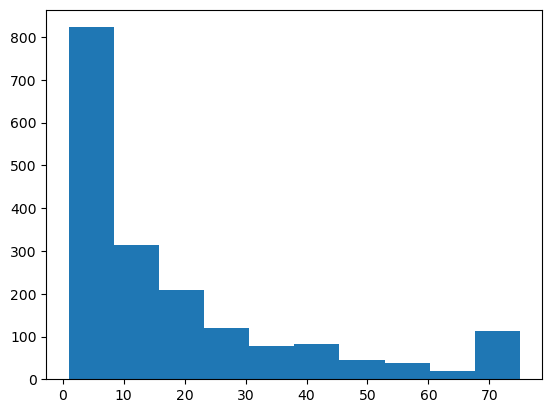

In [15]:
plt.hist([len(track) for track in tracks])

(array([44., 41., 35., 19., 16., 21., 14., 11., 26., 86.]),
 array([36. , 39.9, 43.8, 47.7, 51.6, 55.5, 59.4, 63.3, 67.2, 71.1, 75. ]),
 <BarContainer object of 10 artists>)

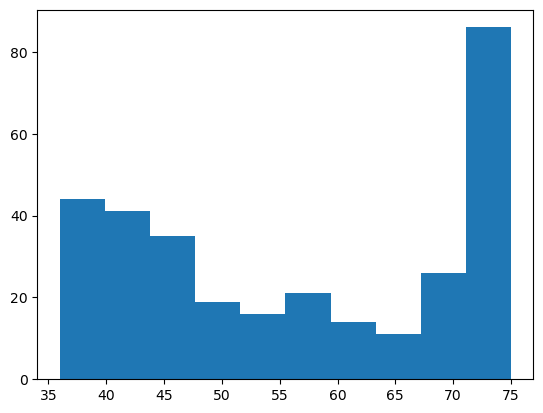

In [25]:
plt.hist([len(track) for track in tracks if len(track) >35])

In [27]:
len([len(track) for track in tracks if len(track) >35])

313

In [28]:
len([len(track) for track in tracks if len(track) <35])

1516

In [29]:
len([len(track) for track in tracks if len(track) >74])

54

In [30]:
long_tracks = [track for track in tracks if len(track) >74]

In [31]:
long_tracks[0]

OrderedDict([('ID', 275), ('t', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), ('x', [931.1360473632812, 931.4351806640625, 932.2725830078125, 935.0612182617188, 934.9136352539062, 939.7393188476562, 940.6480102539062, 939.3088989257812, 941.2420043945312, 945.127685546875, 944.6160278320312, 946.7655639648438, 947.7198486328125, 939.1224365234375, 939.6019287109375, 943.5176391601562, 940.61181640625, 941.3753736723322, 940.9415893554688, 940.4860229492188, 938.2515869140625, 937.4024047851562, 936.916259765625, 934.7605590820312, 932.0419311523438, 929.0020751953125, 924.315673828125, 924.0750732421875, 916.656982421875, 915.4249877929688, 911.2318725585938, 905.5018920898438, 902.1839599609375, 895.5797729492188, 892.4553833007812, 888.1036376953125, 874.1856079101562, 874.2754516601562, 875.8949584960938, 873.0151977539062, 879.1033325195312, 883.8483276367188, 889.82470703125, 900.9808959960938, 908.7113037109375, 914.1744995117188, 923.2612915039062, 919.7515869140625, 921.4136962890625, 915.9855346679688, 913.2452392578125, 912.3818359375, 906.7420654296875, 901.1260986328125, 897.0525512695312, 900.3583984375, 895.0830078125, 894.4363403320312, 893.2095947265625, 891.1918334960938, 886.939697265625, 879.798828125, 877.7203369140625, 876.9771728515625, 879.4557495117188, 879.18798828125, 875.4873657226562, 877.0985717773438, 883.49169921875, 890.0316772460938, 893.3495483398438, 898.50390625, 908.187744140625, 912.1548461914062, 919.2984008789062]), ('y', [11.95483112335205, 9.454870223999023, 10.7081937789917, 12.5691556930542, 13.580645561218262, 13.380518913269043, 13.859195709228516, 14.619483947753906, 17.424083709716797, 12.82763385772705, 13.488561630249023, 11.91843318939209, 13.058788299560547, 11.867037773132324, 10.822237014770508, 10.51762866973877, 15.784232139587402, 16.694327395021133, 17.464441299438477, 16.835079193115234, 18.555118560791016, 19.256893157958984, 20.038904190063477, 19.427230834960938, 22.51580810546875, 22.241331100463867, 22.236141204833984, 20.817096710205078, 19.59248161315918, 18.699424743652344, 19.474637985229492, 18.017549514770508, 16.332515716552734, 15.059621810913086, 15.419144630432129, 15.018269538879395, 16.57357406616211, 18.211423873901367, 22.845495223999023, 27.0189266204834, 29.497802734375, 30.94272804260254, 35.970096588134766, 40.024444580078125, 37.18600845336914, 37.546600341796875, 29.961624145507812, 28.638275146484375, 23.63289451599121, 19.54564666748047, 22.093120574951172, 19.907794952392578, 18.298364639282227, 19.606834411621094, 23.943340301513672, 25.84396743774414, 19.950105667114258, 19.23305892944336, 19.199670791625977, 19.518314361572266, 18.542835235595703, 19.126249313354492, 20.568729400634766, 27.031831741333008, 25.46308135986328, 26.06968116760254, 27.462142944335938, 31.041643142700195, 36.441856384277344, 35.875953674316406, 36.6568489074707, 33.35118103027344, 33.78535842895508, 29.490951538085938, 29.17998504638672]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7186616573206941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 275), ('root', 275), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_palette("rocket_r")


  0%|          | 0/54 [00:00<?, ?it/s]

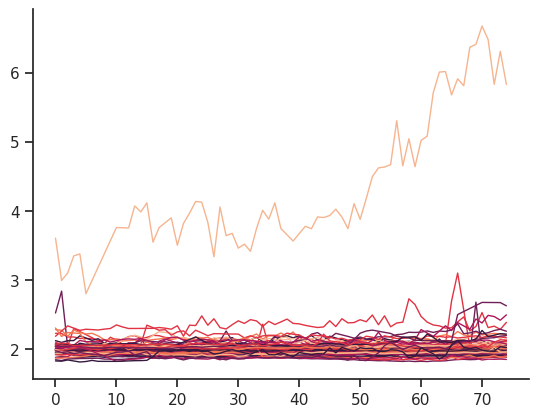

In [33]:
for n, i in tqdm(enumerate(long_tracks), total = len(long_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
#                      label =label, 
                     linewidth = 1
                      )
    sns.despine(offset=0) 

# Handpicking cells

In [20]:
IDs = [2239, 86, 969, 370, ### high int
      275, 287, 211, 245] ### low int

In [21]:
interest_tracks = [track for track in tracks if track.ID in IDs]

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'Intracellular Mtb content \n(Relative fluorescent intensity)')

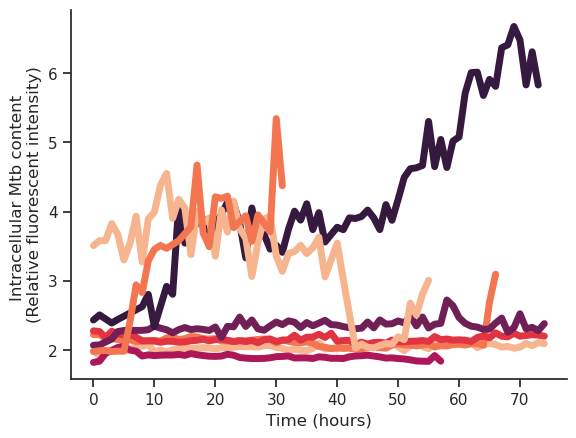

In [197]:
for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
#                      label =label, 
                     linewidth = 5
                      )
    sns.despine(offset=0) 
plt.xlabel('Time (hours)')
plt.ylabel('Intracellular Mtb content \n(Relative fluorescent intensity)')

In [23]:
import seaborn as sns

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'Intracellular Mtb content \n(Relative fluorescent intensity)')

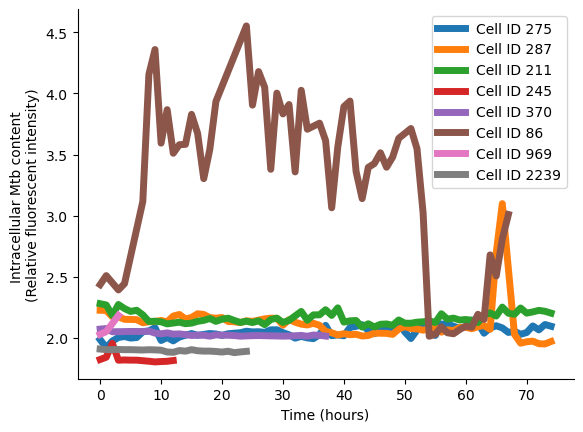

In [24]:
for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
                     label =label, 
                     linewidth = 5
                      )
    sns.despine(offset=0) 
plt.xlabel('Time (hours)')
plt.ylabel('Intracellular Mtb content \n(Relative fluorescent intensity)')

# Smoothing

In [172]:
import pandas as pd

In [175]:
list(pd.Series(y).interpolate())

[1.8238063978338412,
 1.8423547041213306,
 1.9558947199437107,
 1.9979902656557842,
 2.0400858113678577,
 2.059135158518671,
 2.0026590888096947,
 1.9866685577606347,
 1.9162170584960105,
 1.9332179297486083,
 1.9224011062918793,
 1.9286831859956515,
 1.9310088618486023,
 1.9312014530688792,
 1.9391299071725172,
 1.926223490471384,
 1.9521400001465095,
 1.9351059714077221,
 1.9235906701330927,
 1.913669931566415,
 1.9109942066963226,
 1.9162477279734182,
 1.9418001774807818,
 1.9282658015907763,
 1.8955693773972453,
 1.8861938177842865,
 1.8806517845821817,
 1.8793597979245373,
 1.882248709220338,
 1.891039996952278,
 1.907390656404174,
 1.9107558689911304,
 1.9166916117996264,
 1.8881159404562442,
 1.8900657758384352,
 1.889373671892682,
 1.8808417085085438,
 1.9054035575194062,
 1.8981143288228348,
 1.8825927807260852,
 1.8837164873296874,
 1.8801693171757305,
 1.9052384776333728,
 1.9168910754017714,
 1.9207964926917096,
 1.929257111630691,
 1.9162512325407344,
 1.9043637886827662,


  0%|          | 0/8 [00:00<?, ?it/s]

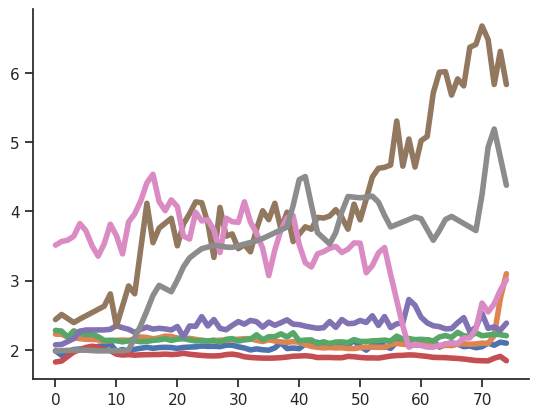

In [185]:
from scipy.interpolate import make_interp_spline, BSpline


for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    x = i.t
    y = i.properties['mean_intensity-1']/1E-17
    y = list(pd.Series(y).interpolate())
    xnew = np.linspace(np.min(x), np.max(x), 75) 
    spl = make_interp_spline(x, y, k=1)
    y_smooth = spl(xnew)
    sns.lineplot(data =y_smooth, 
#                      label =label, 
                     linewidth = 4
                      )
    sns.despine(offset=0) 

In [186]:
from scipy.interpolate import interp1d

  0%|          | 0/8 [00:00<?, ?it/s]

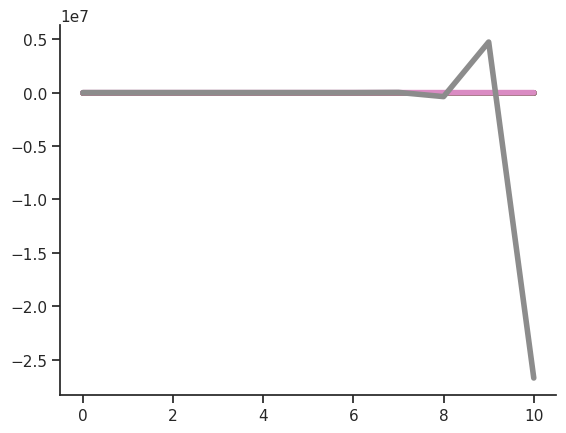

In [192]:
for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    x = i.t
    y = i.properties['mean_intensity-1']/1E-17
    y = list(pd.Series(y).interpolate())
#     x_ = np.linspace(np.min(x), np.max(x), len(x)) 
    p = np.polyfit(x, y, 10)
    sns.lineplot(data =p, 
#                      label =label, 
                     linewidth = 4
                      )
    sns.despine(offset=0) 

# Build pandas df of tracks?

# Previous graph format

In [ ]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, 
                      figsize = (9,7))
for n, i in enumerate(plot_rfp_dfs[0].items()):
    label = i[0] + f',(3,{n+4})'
    LHS = sns.lineplot(data = i[1]/1E10,ax=ax[0], label =label, 
                     linewidth = 4
                      )
    sns.despine(ax=ax[0], offset=0) 
    
LHS.set(ylabel = None)
for n, i in enumerate(plot_rfp_dfs[2].items()):
    label = i[0] + f',(5,{n+4})'
    sns.lineplot(data = i[1]/1E10,ax=ax[1], label =label,
                 linewidth = 4
                )
    sns.despine(ax=ax[1], offset=0) # the important part here
plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle('Mtb growth over the whole field of view (Replication_IPSDM_GFP dataset)')
fig.show()
# plt.savefig('/mnt/DATA/macrohet/results/whole_fov_mtb_growth/single_tile_whole_fov_mtb_growth_row3&5.png', bbox_inches = 'tight', dpi = 314)